# Команда TEAM DREAM

**Состав команды:**
- Рыжков Максим (TM, PM, DA)
- Ли Сюань Линь
- Халиков Рифат Шавкатович (DA)
- Карманов Максим
- Буржимский Сергей Александрович (ML)
- Перминов Артем Александрович (ML, PM)

# КЕЙС №8: Прогнозирование стоимости компании

## Краткое описание кейса

Требуется определить рыночную капитализацию (Market Cap) компаний на основе косвенных признаков, таких как:
- Финансовые показатели (EBITDA, Price/Earnings, Price/Sales)
- Рыночные данные (цены акций, дивидендная доходность)
- Отраслевая принадлежность (сектор экономики)

## Ожидаемый результат

Обученная модель регрессии, предсказывающая рыночную капитализацию компании по финансовым данным.

## Основной функционал проекта

1. **Сбор и подготовка данных** — загрузка финансовых отчётов
2. **EDA (Exploratory Data Analysis)** — визуальный анализ и статистика
3. **Feature Engineering** — создание новых признаков
4. **Обучение моделей** — сравнение различных алгоритмов:
   - Linear Regression (baseline)
   - Gradient Boosting
   - XGBoost
   - LightGBM
   - Ensemble (комбинация моделей)
5. **Оценка и интерпретация** — метрики качества, SHAP-анализ
6. **Деплой** — FastAPI сервер для получения предсказаний

# 1. Импорт библиотек

In [19]:
# Основные библиотеки для работы с данными
import pandas as pd  
import numpy as np    

# Визуализация
import matplotlib.pyplot as plt      
import seaborn as sns                  

# Машинное обучение - подготовка данных
from sklearn.model_selection import train_test_split, cross_val_score, KFold
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.impute import SimpleImputer

# Модели
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from xgboost import XGBRegressor
from lightgbm import LGBMRegressor

# Метрики качества
from sklearn.metrics import (
    mean_squared_error, 
    mean_absolute_error, 
    r2_score
)

# Статистика
from scipy import stats

# Настройка визуализации
sns.set_style("whitegrid")
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 8)
plt.rcParams['font.size'] = 11

# Игнорируем предупреждения для чистоты вывода
import warnings
warnings.filterwarnings('ignore')

print("Все библиотеки успешно импортированы")

Все библиотеки успешно импортированы


# 2. Загрузка и первичный анализ данных

In [2]:
# Загружаем данные
df = pd.read_csv('../data/financials.csv')

print(f"Размер датасета: {df.shape[0]} строк, {df.shape[1]} столбцов")
print("\nПервые 5 строк:")
df.head()

Размер датасета: 505 строк, 14 столбцов

Первые 5 строк:


,Symbol,Name,Sector,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book,SEC Filings
0,MMM,3M Company,Industrials,222.89,24.31,2.332862,7.92,259.77,175.490,1.387211e+11,9.048000e+09,4.390271,11.34,http://www.sec.gov/cgi-bin/browse-edgar?action...
1,AOS,A.O. Smith Corp,Industrials,60.24,27.76,1.147959,1.70,68.39,48.925,1.078342e+10,6.010000e+08,3.575483,6.35,http://www.sec.gov/cgi-bin/browse-edgar?action...
2,ABT,Abbott Laboratories,Health Care,56.27,22.51,1.908982,0.26,64.60,42.280,1.021210e+11,5.744000e+09,3.740480,3.19,http://www.sec.gov/cgi-bin/browse-edgar?action...
3,ABBV,AbbVie Inc.,Health Care,108.48,19.41,2.499560,3.29,125.86,60.050,1.813863e+11,1.031000e+10,6.291571,26.14,http://www.sec.gov/cgi-bin/browse-edgar?action...
4,ACN,Accenture plc,Information Technology,150.51,25.47,1.714470,5.44,162.60,114.820,9.876586e+10,5.643228e+09,2.604117,10.62,http://www.sec.gov/cgi-bin/browse-edgar?action...


In [20]:
# Информация о данных
print("Информация о типах данных и пропусках:")
df.info()


print("Статистическое описание числовых признаков:")

df.describe()

Информация о типах данных и пропусках:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 505 entries, 0 to 504
Data columns (total 14 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Symbol          505 non-null    object 
 1   Name            505 non-null    object 
 2   Sector          505 non-null    object 
 3   Price           505 non-null    float64
 4   Price/Earnings  503 non-null    float64
 5   Dividend Yield  505 non-null    float64
 6   Earnings/Share  505 non-null    float64
 7   52 Week Low     505 non-null    float64
 8   52 Week High    505 non-null    float64
 9   Market Cap      505 non-null    float64
 10  EBITDA          505 non-null    float64
 11  Price/Sales     505 non-null    float64
 12  Price/Book      497 non-null    float64
 13  SEC Filings     505 non-null    object 
dtypes: float64(10), object(4)
memory usage: 55.4+ KB
Статистическое описание числовых признаков:


,Price,Price/Earnings,Dividend Yield,Earnings/Share,52 Week Low,52 Week High,Market Cap,EBITDA,Price/Sales,Price/Book
count,505.000000,503.000000,505.000000,505.000000,505.000000,505.000000,5.050000e+02,5.050000e+02,505.000000,497.000000
mean,103.830634,24.808390,1.895953,3.753743,122.623832,83.536616,4.923944e+10,3.590328e+09,3.941705,14.453179
std,134.427636,41.241081,1.537214,5.689036,155.362140,105.725473,9.005017e+10,6.840544e+09,3.460110,89.660508
min,2.820000,-251.530000,0.000000,-28.010000,6.590000,2.800000,2.626102e+09,-5.067000e+09,0.153186,0.510000
25%,46.250000,15.350000,0.794834,1.490000,56.250000,38.430000,1.273207e+10,7.739320e+08,1.629490,2.020000
50%,73.920000,19.450000,1.769255,2.890000,86.680000,62.850000,2.140095e+10,1.614399e+09,2.896440,3.400000
75%,116.540000,25.750000,2.781114,5.140000,140.130000,96.660000,4.511968e+10,3.692749e+09,4.703842,6.110000
max,1806.060000,520.150000,12.661196,44.090000,2067.990000,1589.000000,8.095080e+11,7.938600e+10,20.094294,1403.380000


## Описание признаков

### Идентификационные признаки:
- **Symbol** — биржевой тикер компании
- **Name** — полное название компании
- **Sector** — сектор экономики
- **SEC Filings** — ссылка на отчёты в SEC

### Рыночные показатели:
- **Price** — текущая цена акции
- **52 Week Low** — минимальная цена за 52 недели
- **52 Week High** — максимальная цена за 52 недели
- **Market Cap** — рыночная капитализация (**целевая переменная**)

### Показатели доходности:
- **Earnings/Share (EPS)** — прибыль на акцию
- **Dividend Yield** — дивидендная доходность

### Оценочные коэффициенты:
- **Price/Earnings (P/E)** — соотношение цены к прибыли
- **Price/Sales (P/S)** — соотношение цены к выручке
- **Price/Book (P/B)** — соотношение цены к балансовой стоимости

### Показатели эффективности:
- **EBITDA** — прибыль до вычета процентов, налогов, износа и амортизации

Пропущенные значения:
                Пропусков   Процент
Price/Book              8  1.584158
Price/Earnings          2  0.396040


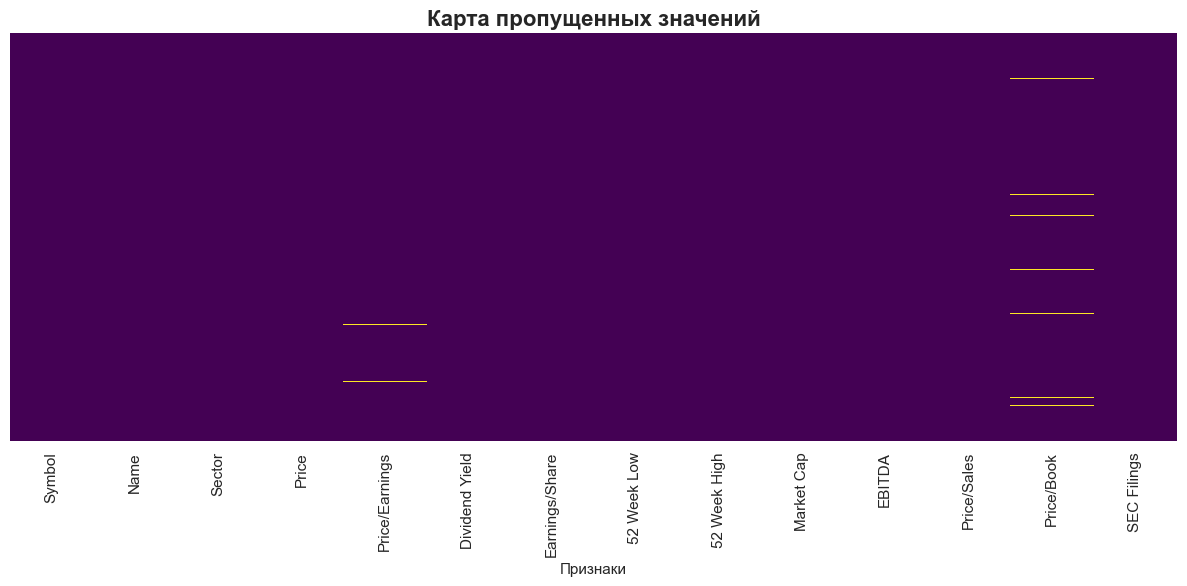

In [4]:
# Анализ пропущенных значений
missing = df.isnull().sum()
missing_pct = 100 * missing / len(df)
missing_df = pd.DataFrame({
    'Пропусков': missing, 
    'Процент': missing_pct
}).sort_values(by='Пропусков', ascending=False)

print("Пропущенные значения:")
print(missing_df[missing_df['Пропусков'] > 0])

# Визуализация пропусков
plt.figure(figsize=(12, 6))
sns.heatmap(df.isnull(), cbar=False, cmap='viridis', yticklabels=False)
plt.title('Карта пропущенных значений', fontsize=16, fontweight='bold')
plt.xlabel('Признаки')
plt.tight_layout()
plt.show()

# 3. Exploratory Data Analysis (EDA)

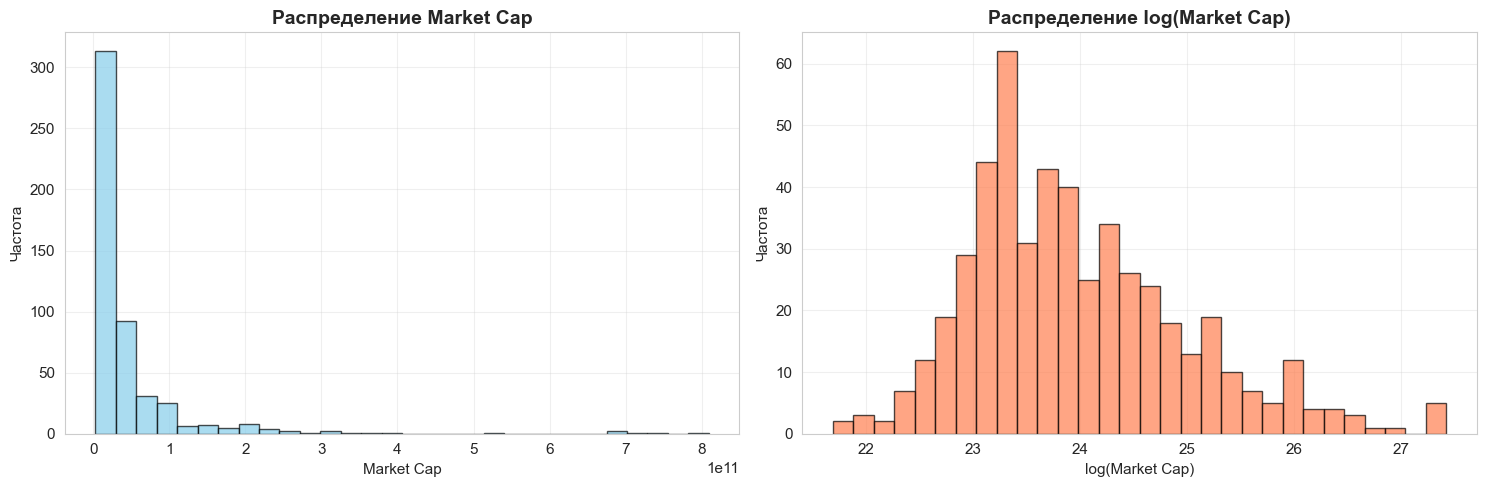

Skewness (асимметрия) исходного распределения: 5.24
Skewness log-распределения: 0.80


In [21]:
# Распределение целевой переменной (Market Cap)
fig, axes = plt.subplots(1, 2, figsize=(15, 5))

# Исходное распределение
axes[0].hist(df['Market Cap'], bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[0].set_title('Распределение Market Cap', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Market Cap')
axes[0].set_ylabel('Частота')
axes[0].grid(alpha=0.3)

# Логарифмическое распределение (более нормальное)
axes[1].hist(np.log1p(df['Market Cap']), bins=30, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_title('Распределение log(Market Cap)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('log(Market Cap)')
axes[1].set_ylabel('Частота')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Skewness (асимметрия) исходного распределения: {df['Market Cap'].skew():.2f}")
print(f"Skewness log-распределения: {np.log1p(df['Market Cap']).skew():.2f}")


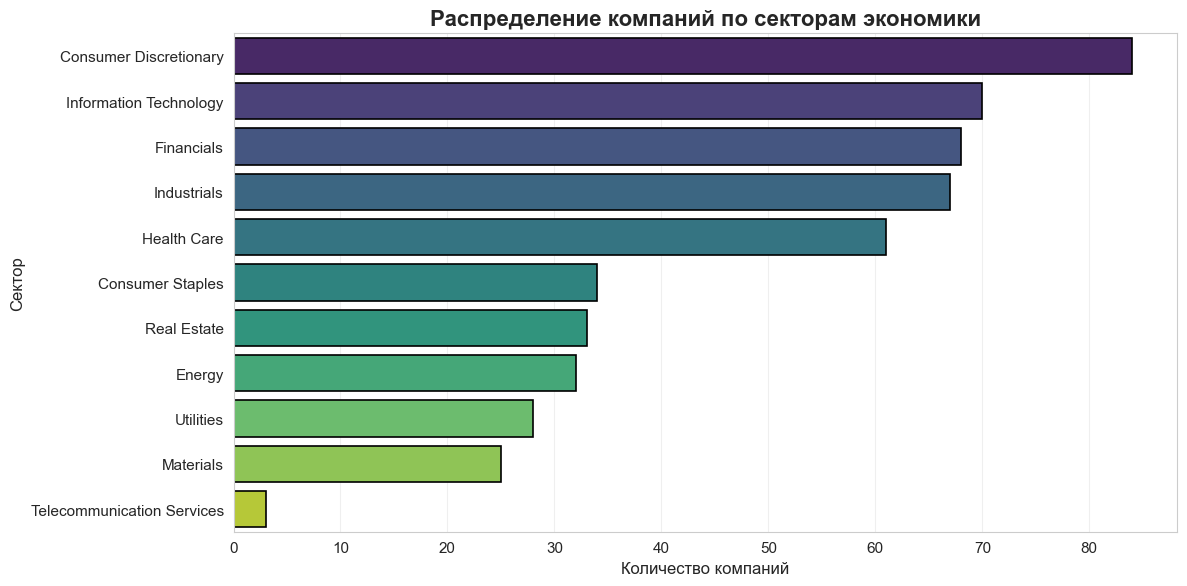


Топ-5 секторов по количеству компаний:
Sector
Consumer Discretionary    84
Information Technology    70
Financials                68
Industrials               67
Health Care               61
Name: count, dtype: int64


In [6]:
# Распределение компаний по секторам
sector_counts = df['Sector'].value_counts()

plt.figure(figsize=(12, 6))
sns.countplot(y='Sector', data=df, order=sector_counts.index, 
              palette='viridis', edgecolor='black', linewidth=1.2)
plt.title('Распределение компаний по секторам экономики', fontsize=16, fontweight='bold')
plt.xlabel('Количество компаний', fontsize=12)
plt.ylabel('Сектор', fontsize=12)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

print("\nТоп-5 секторов по количеству компаний:")
print(sector_counts.head())

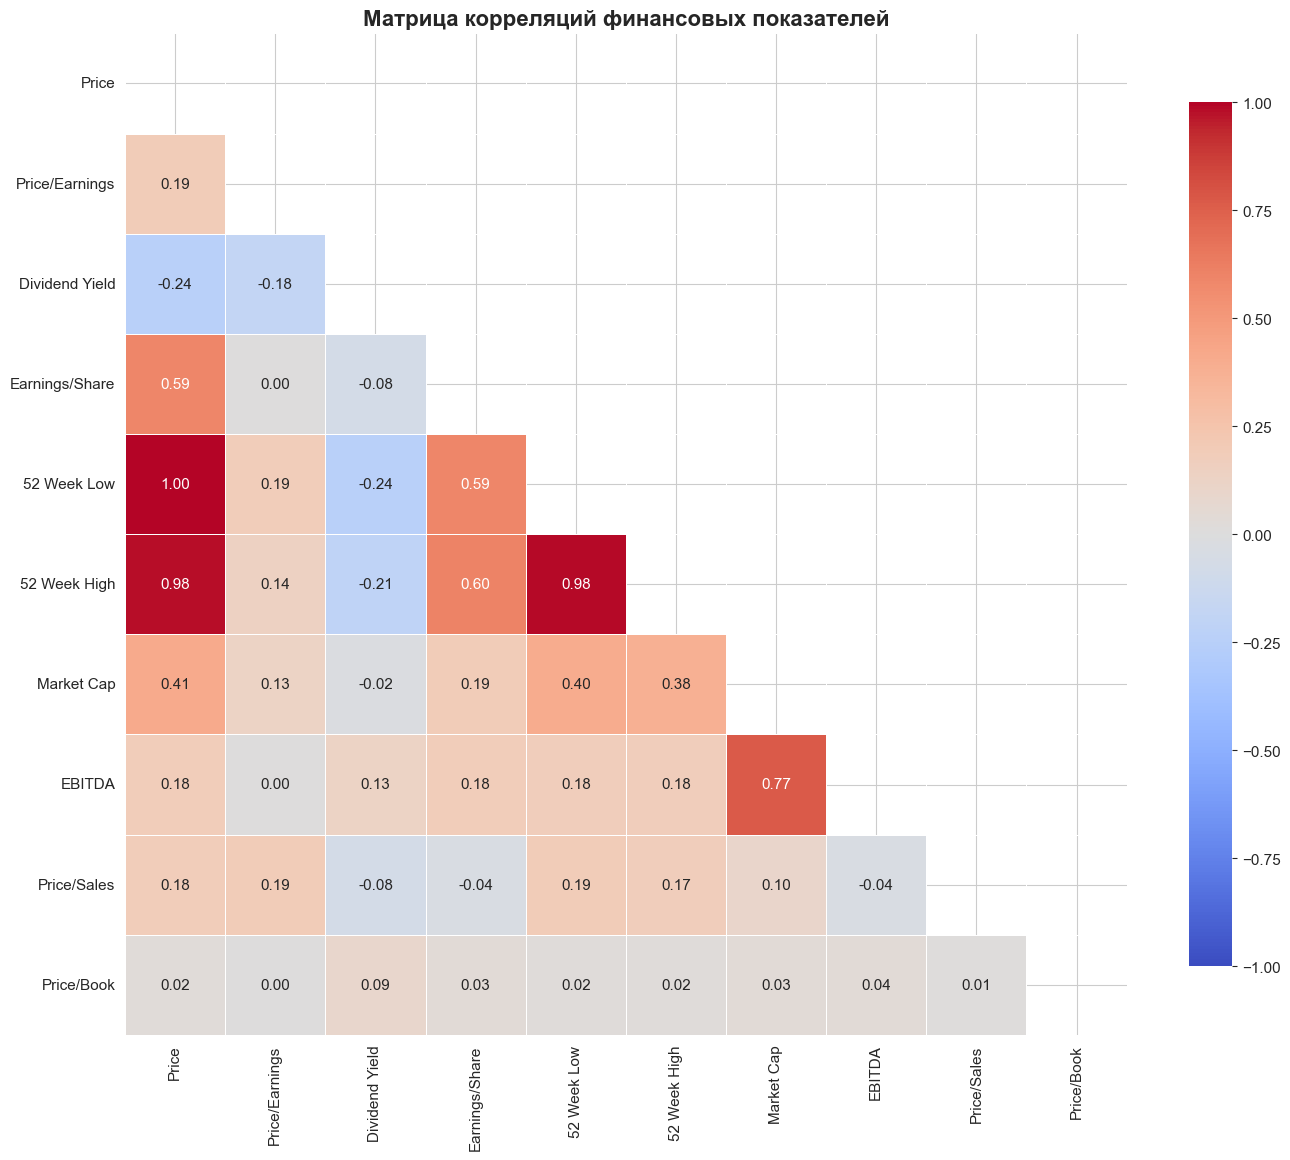


Корреляция признаков с Market Cap:
Market Cap        1.000000
EBITDA            0.771344
Price             0.406474
52 Week Low       0.398504
52 Week High      0.375588
Earnings/Share    0.194063
Price/Earnings    0.131381
Price/Sales       0.095249
Price/Book        0.034411
Dividend Yield   -0.021794
Name: Market Cap, dtype: float64


In [31]:
# Корреляционный анализ
numeric_df = df.select_dtypes(include=[np.number])
corr_matrix = numeric_df.corr()

# Матрица корреляций
plt.figure(figsize=(14, 12))
mask = np.triu(np.ones_like(corr_matrix, dtype=bool))
sns.heatmap(corr_matrix, mask=mask, annot=True, cmap='coolwarm', 
            center=0, vmin=-1, vmax=1, fmt='.2f',
            square=True, linewidths=0.5, cbar_kws={'shrink': 0.8})
plt.title('Матрица корреляций финансовых показателей', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

# Топ корреляций с Market Cap
print("\nКорреляция признаков с Market Cap:")
correlation_with_target = corr_matrix['Market Cap'].sort_values(ascending=False)
print(correlation_with_target)

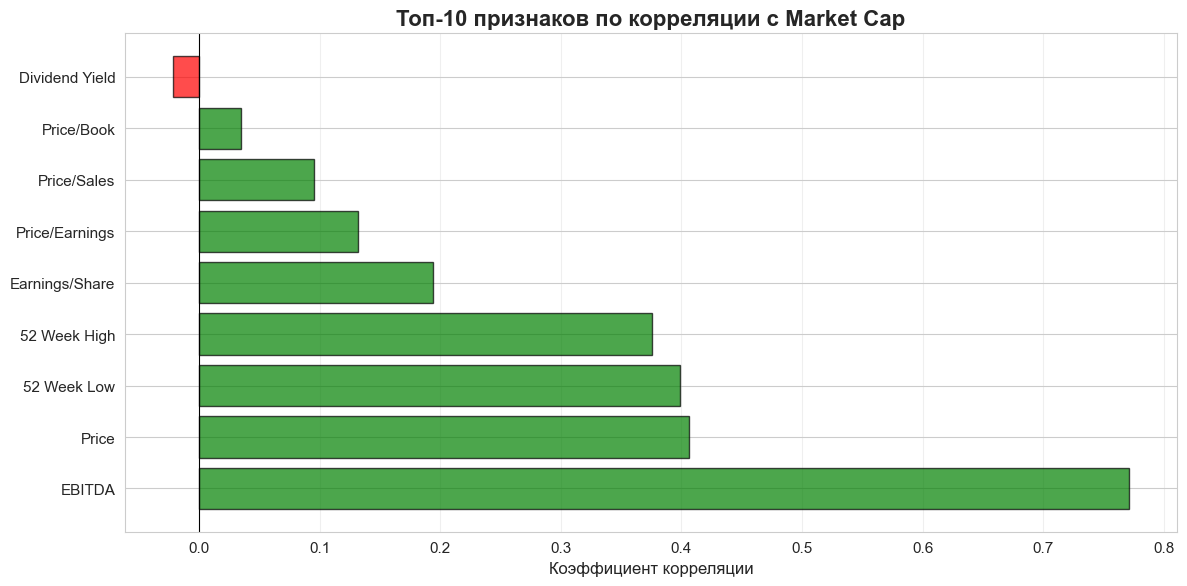

In [8]:
# Визуализация топ-10 корреляций с Market Cap
top_corr = correlation_with_target.drop('Market Cap').head(10)

plt.figure(figsize=(12, 6))
colors = ['green' if x > 0 else 'red' for x in top_corr.values]
plt.barh(range(len(top_corr)), top_corr.values, color=colors, alpha=0.7, edgecolor='black')
plt.yticks(range(len(top_corr)), top_corr.index)
plt.xlabel('Коэффициент корреляции', fontsize=12)
plt.title('Топ-10 признаков по корреляции с Market Cap', fontsize=16, fontweight='bold')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.grid(axis='x', alpha=0.3)
plt.tight_layout()
plt.show()

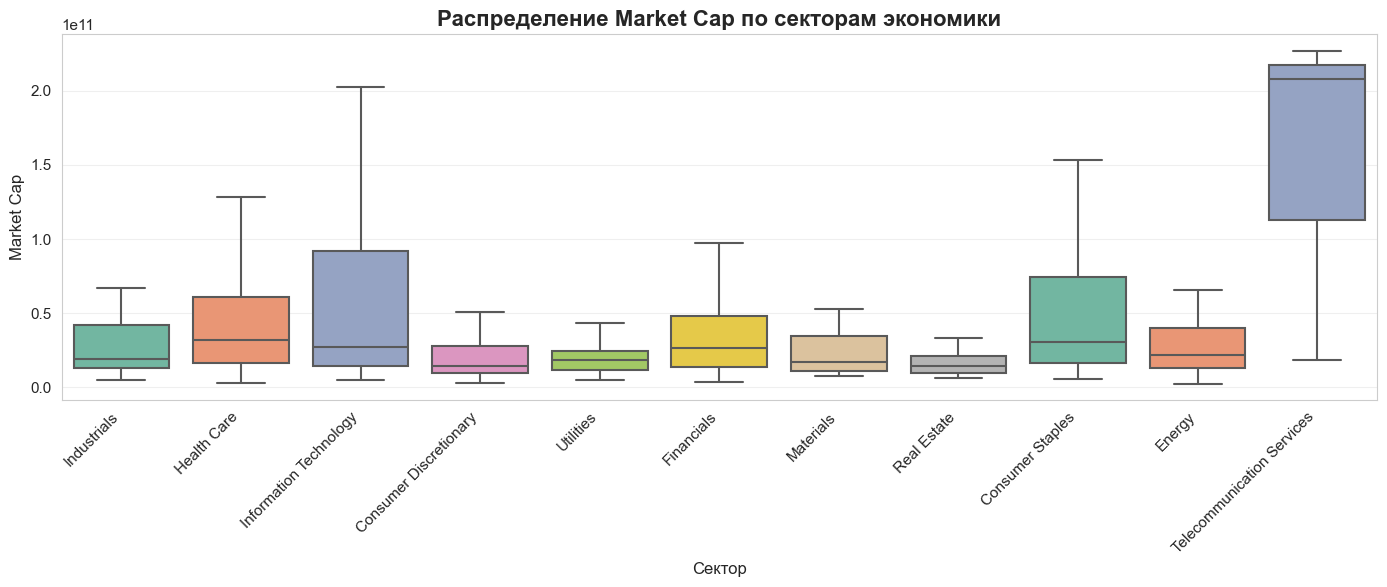

In [9]:
# Boxplot: Market Cap по секторам
plt.figure(figsize=(14, 6))
sns.boxplot(x='Sector', y='Market Cap', data=df, 
            palette='Set2', showfliers=False, linewidth=1.5)
plt.xticks(rotation=45, ha='right')
plt.title('Распределение Market Cap по секторам экономики', fontsize=16, fontweight='bold')
plt.xlabel('Сектор', fontsize=12)
plt.ylabel('Market Cap', fontsize=12)
plt.grid(axis='y', alpha=0.3)
plt.tight_layout()
plt.show()

# 4. Предобработка данных

In [10]:
# Создаём копию данных для обработки
df_clean = df.copy()

# Удаляем идентификационные признаки (не несут предсказательной силы)
df_clean = df_clean.drop(['Symbol', 'Name', 'SEC Filings'], axis=1)

# Заполняем пропущенные значения медианой для числовых признаков
numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
df_clean[numeric_cols] = df_clean[numeric_cols].fillna(df_clean[numeric_cols].median())

# One-Hot кодирование для категориального признака 'Sector'
df_clean = pd.get_dummies(df_clean, columns=['Sector'], prefix='Sector', drop_first=True)

# Удаляем выбросы (топ 1% по Market Cap)
q99 = df_clean['Market Cap'].quantile(0.99)
df_clean = df_clean[df_clean['Market Cap'] <= q99]

print(f"Размер данных после очистки: {df_clean.shape}")
print(f"Удалено выбросов: {df.shape[0] - df_clean.shape[0]}")
print(f"\n✓ Предобработка завершена")

Размер данных после очистки: (499, 20)
Удалено выбросов: 6

✓ Предобработка завершена


In [22]:
# Feature Engineering: создание новых признаков
print("Создание новых признаков...\n")

# Соотношения (Ratios)
if 'EBITDA' in df_clean.columns and 'Price' in df_clean.columns:
    df_clean['EBITDA_Price_Ratio'] = df_clean['EBITDA'] / df_clean['Price'].clip(lower=1e-6)
    print(" Создан признак: EBITDA_Price_Ratio")

if 'Earnings/Share' in df_clean.columns and 'Price' in df_clean.columns:
    df_clean['Earnings_Price_Ratio'] = df_clean['Earnings/Share'] / df_clean['Price'].clip(lower=1e-6)
    print(" Создан признак: Earnings_Price_Ratio")

# Логарифмические преобразования для стабилизации распределения
for col in ['Price', 'EBITDA', 'Price/Sales']:
    if col in df_clean.columns:
        df_clean[f'{col}_log'] = np.log1p(df_clean[col].clip(lower=0))
        print(f" Создан признак: {col}_log")

print(f"\nИтоговое количество признаков: {df_clean.shape[1]}")

Создание новых признаков...

 Создан признак: EBITDA_Price_Ratio
 Создан признак: Earnings_Price_Ratio
 Создан признак: Price_log
 Создан признак: EBITDA_log
 Создан признак: Price/Sales_log

Итоговое количество признаков: 25


In [23]:
# Разделение на признаки и целевую переменную
X = df_clean.drop('Market Cap', axis=1)
y = np.log1p(df_clean['Market Cap'])  # Логарифмируем целевую переменную

# Разделение на обучающую и тестовую выборки (80/20)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42
)

# Масштабирование признаков (RobustScaler устойчив к выбросам)
scaler = RobustScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"Размер обучающей выборки: {X_train.shape}")
print(f"Размер тестовой выборки: {X_test.shape}")

Размер обучающей выборки: (399, 24)
Размер тестовой выборки: (100, 24)


# 5. Обучение и сравнение моделей

In [24]:
# Определяем модели для сравнения
models = {
    'Linear Regression': LinearRegression(),
    'Gradient Boosting': GradientBoostingRegressor(random_state=42, n_estimators=200, 
                                                     learning_rate=0.1, max_depth=5),
    'XGBoost': XGBRegressor(random_state=42, n_estimators=200, learning_rate=0.1, 
                            max_depth=5, verbosity=0),
    'LightGBM': LGBMRegressor(random_state=42, n_estimators=200, learning_rate=0.1, 
                              max_depth=5, verbose=-1)
}

print("Модели для обучения:")
for name in models.keys():
    print(f"   {name}")

Модели для обучения:
   Linear Regression
   Gradient Boosting
   XGBoost
   LightGBM


In [26]:
# Обучение моделей и сбор метрик
results = []

for name, model in models.items():
       
    # Для линейной регрессии используем масштабированные данные
    if name == 'Linear Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        # Gradient Boosting методы не требуют масштабирования
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    
    # Возвращаем к исходной шкале для расчёта метрик
    y_test_orig = np.expm1(y_test)
    y_pred_orig = np.expm1(y_pred)
    
    # Рассчитываем метрики
    r2 = r2_score(y_test_orig, y_pred_orig)
    mae = mean_absolute_error(y_test_orig, y_pred_orig)
    rmse = np.sqrt(mean_squared_error(y_test_orig, y_pred_orig))
    
    # Cross-validation на обучающей выборке
    if name == 'Linear Regression':
        cv_scores = cross_val_score(model, X_train_scaled, y_train, cv=5, scoring='r2')
    else:
        cv_scores = cross_val_score(model, X_train, y_train, cv=5, scoring='r2')
    
    cv_r2 = cv_scores.mean()
    
    results.append({
        'Model': name,
        'R²': r2,
        'MAE': mae,
        'RMSE': rmse,
        'CV R²': cv_r2
    })
    
    print(f"  R²: {r2:.4f}")
    print(f"  MAE: {mae:,.0f}")
    print(f"  RMSE: {rmse:,.0f}")
    print(f"  CV R² (mean): {cv_r2:.4f}")

  R²: -1.3261
  MAE: 20,680,839,728
  RMSE: 61,822,043,955
  CV R² (mean): 0.5158
  R²: 0.7959
  MAE: 11,125,889,499
  RMSE: 18,314,735,786
  CV R² (mean): 0.6565
  R²: 0.8116
  MAE: 10,471,098,591
  RMSE: 17,595,354,203
  CV R² (mean): 0.6494
  R²: 0.7760
  MAE: 11,080,371,932
  RMSE: 19,184,177,576
  CV R² (mean): 0.6507


In [29]:
# Создаём таблицу результатов
results_df = pd.DataFrame(results)
results_df = results_df.sort_values('R²', ascending=False)

print("СРАВНЕНИЕ МОДЕЛЕЙ")
print(results_df.to_string(index=False))

best_model = results_df.iloc[0]['Model']
best_r2 = results_df.iloc[0]['R²']
print(f"\n Лучшая модель: {best_model} (R² = {best_r2:.4f})")

СРАВНЕНИЕ МОДЕЛЕЙ
            Model        R²          MAE         RMSE    CV R²
          XGBoost  0.811576 1.047110e+10 1.759535e+10 0.649399
Gradient Boosting  0.795854 1.112589e+10 1.831474e+10 0.656521
         LightGBM  0.776011 1.108037e+10 1.918418e+10 0.650743
Linear Regression -1.326089 2.068084e+10 6.182204e+10 0.515829

 Лучшая модель: XGBoost (R² = 0.8116)


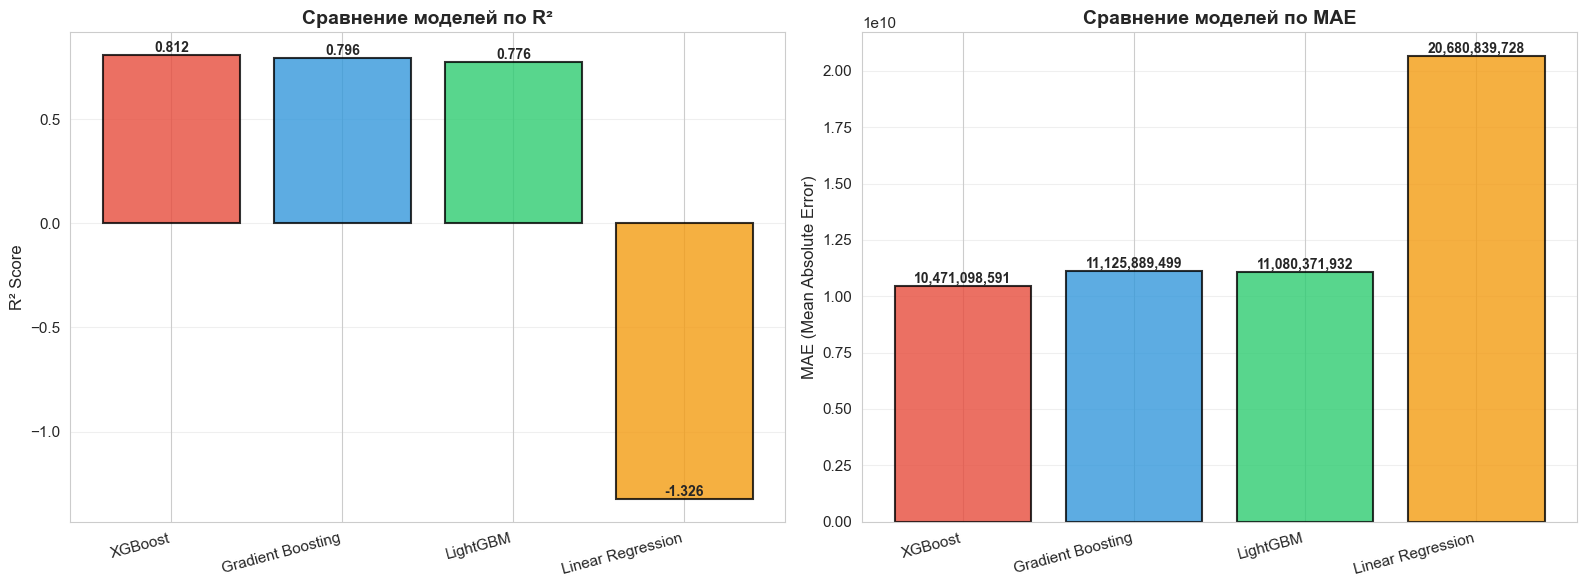

In [16]:
# Визуализация сравнения моделей
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График R²
colors = ['#e74c3c', '#3498db', '#2ecc71', '#f39c12']
bars1 = axes[0].bar(results_df['Model'], results_df['R²'], color=colors, 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
axes[0].set_ylabel('R² Score', fontsize=12)
axes[0].set_title('Сравнение моделей по R²', fontsize=14, fontweight='bold')
axes[0].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[0].grid(axis='y', alpha=0.3)

# Добавляем значения над столбиками
for bar in bars1:
    height = bar.get_height()
    axes[0].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:.3f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

# График MAE
bars2 = axes[1].bar(results_df['Model'], results_df['MAE'], color=colors, 
                     alpha=0.8, edgecolor='black', linewidth=1.5)
axes[1].set_ylabel('MAE (Mean Absolute Error)', fontsize=12)
axes[1].set_title('Сравнение моделей по MAE', fontsize=14, fontweight='bold')
axes[1].set_xticklabels(results_df['Model'], rotation=15, ha='right')
axes[1].grid(axis='y', alpha=0.3)

# Добавляем значения над столбиками
for bar in bars2:
    height = bar.get_height()
    axes[1].text(bar.get_x() + bar.get_width()/2., height,
                f'{height:,.0f}', ha='center', va='bottom', fontsize=10, fontweight='bold')

plt.tight_layout()
plt.show()

# 6. Анализ важности признаков

Топ-15 важных признаков для модели XGBoost:
             feature  importance
          EBITDA_log    0.715380
              EBITDA    0.087872
   Sector_Financials    0.035325
  EBITDA_Price_Ratio    0.022273
      Price/Earnings    0.020518
         Price/Sales    0.019386
  Sector_Health Care    0.013028
Earnings_Price_Ratio    0.012094
         52 Week Low    0.010288
    Sector_Utilities    0.009784
      Dividend Yield    0.009600
          Price/Book    0.009234
               Price    0.008838
       Sector_Energy    0.006982
        52 Week High    0.005918


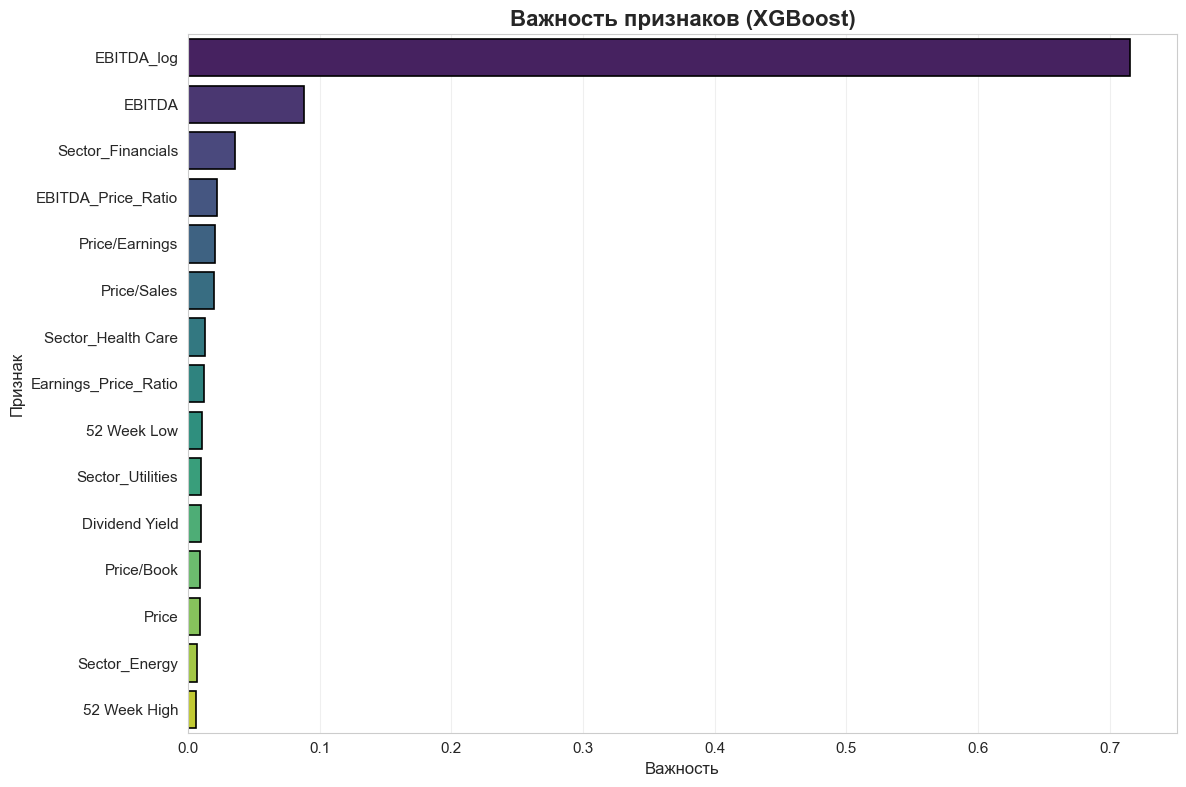

In [28]:
# Получаем важность признаков для лучшей модели
best_model_name = results_df.iloc[0]['Model']
best_model_obj = models[best_model_name]

# Для Gradient Boosting моделей
if hasattr(best_model_obj, 'feature_importances_'):
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_model_obj.feature_importances_
    }).sort_values('importance', ascending=False).head(15)
    
    print(f"Топ-15 важных признаков для модели {best_model_name}:")
    print(feature_importance.to_string(index=False))
    
    # Визуализация
    plt.figure(figsize=(12, 8))
    sns.barplot(x='importance', y='feature', data=feature_importance, 
                palette='viridis', edgecolor='black', linewidth=1.2)
    plt.title(f'Важность признаков ({best_model_name})', fontsize=16, fontweight='bold')
    plt.xlabel('Важность', fontsize=12)
    plt.ylabel('Признак', fontsize=12)
    plt.grid(axis='x', alpha=0.3)
    plt.tight_layout()
    plt.show()
else:
    print(f"Модель {best_model_name} не поддерживает feature_importances_")

# 7. Визуализация предсказаний

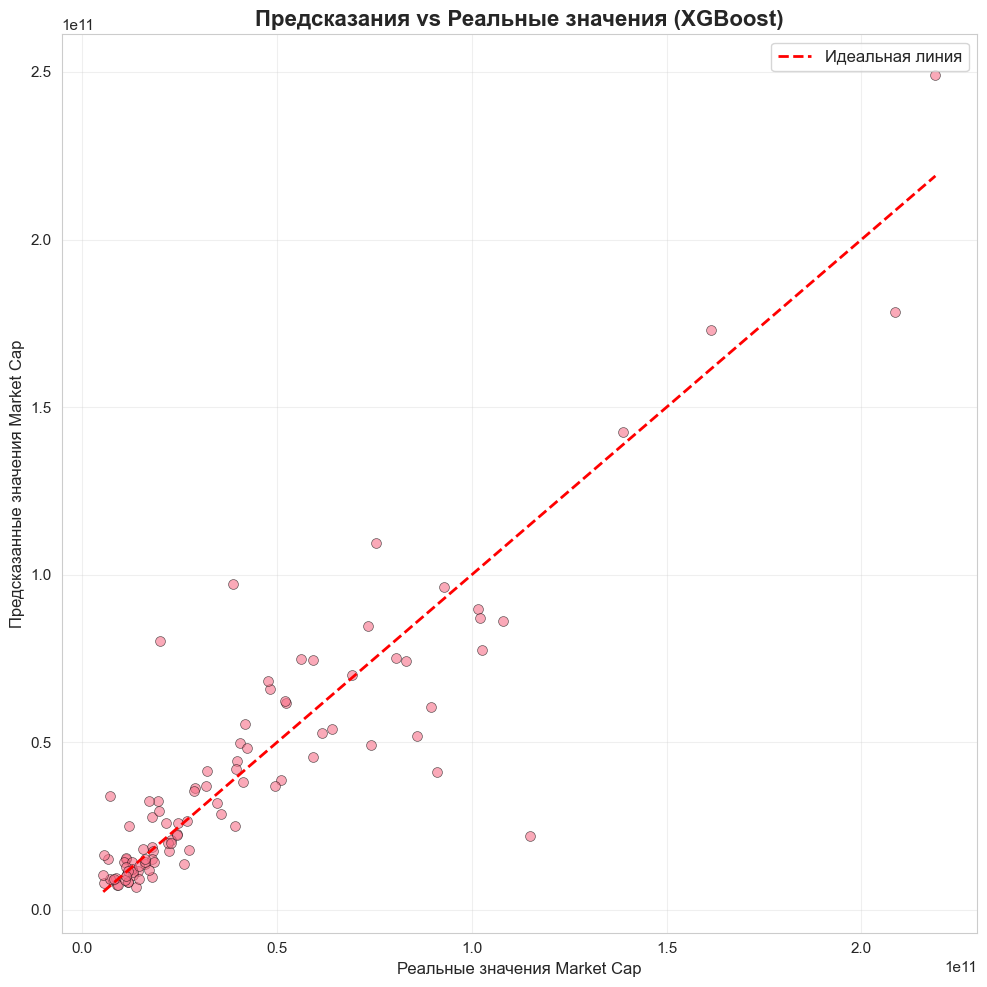

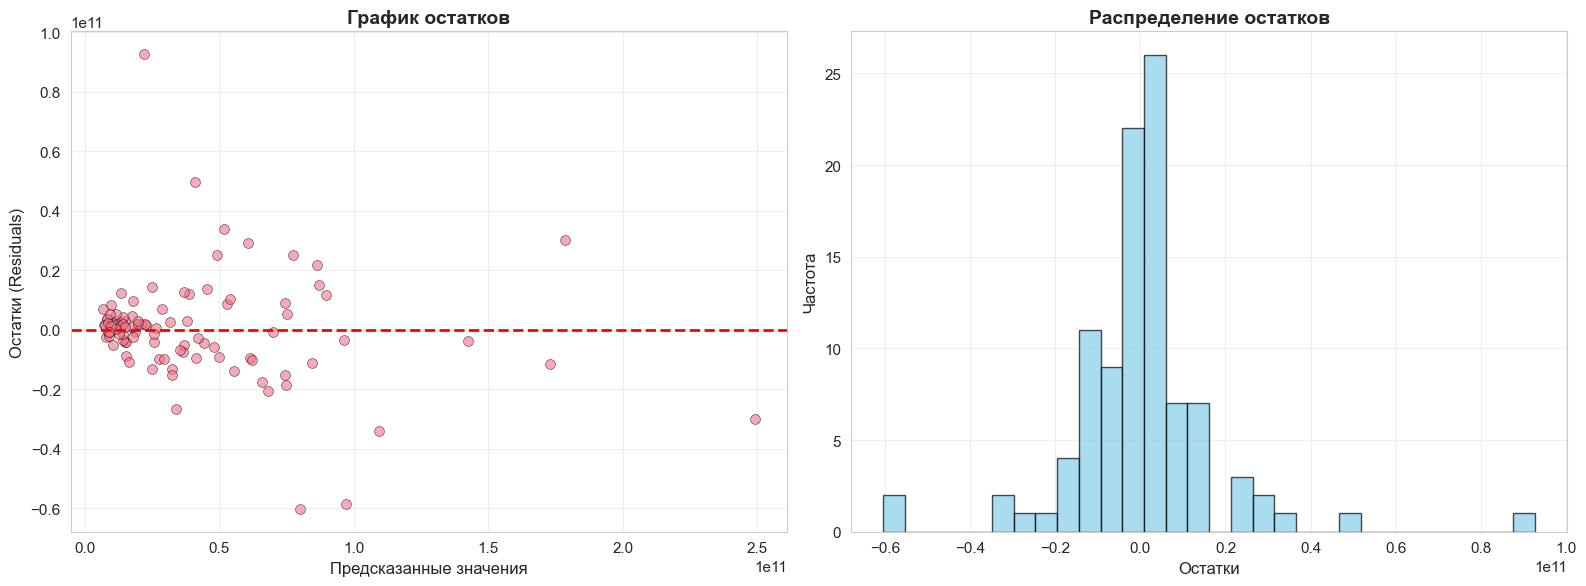

In [18]:
# Предсказания лучшей модели
if best_model_name == 'Linear Regression':
    y_pred_best = best_model_obj.predict(X_test_scaled)
else:
    y_pred_best = best_model_obj.predict(X_test)

y_test_orig = np.expm1(y_test)
y_pred_orig = np.expm1(y_pred_best)

# График: предсказания vs реальные значения
plt.figure(figsize=(10, 10))
plt.scatter(y_test_orig, y_pred_orig, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
plt.plot([y_test_orig.min(), y_test_orig.max()], 
         [y_test_orig.min(), y_test_orig.max()], 
         'r--', linewidth=2, label='Идеальная линия')
plt.xlabel('Реальные значения Market Cap', fontsize=12)
plt.ylabel('Предсказанные значения Market Cap', fontsize=12)
plt.title(f'Предсказания vs Реальные значения ({best_model_name})', 
          fontsize=16, fontweight='bold')
plt.legend(fontsize=12)
plt.grid(alpha=0.3)
plt.tight_layout()
plt.show()

# Анализ остатков (residuals)
residuals = y_test_orig - y_pred_orig

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# График остатков
axes[0].scatter(y_pred_orig, residuals, alpha=0.6, s=50, edgecolor='black', linewidth=0.5)
axes[0].axhline(y=0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Предсказанные значения', fontsize=12)
axes[0].set_ylabel('Остатки (Residuals)', fontsize=12)
axes[0].set_title('График остатков', fontsize=14, fontweight='bold')
axes[0].grid(alpha=0.3)

# Гистограмма остатков
axes[1].hist(residuals, bins=30, alpha=0.7, color='skyblue', edgecolor='black')
axes[1].set_xlabel('Остатки', fontsize=12)
axes[1].set_ylabel('Частота', fontsize=12)
axes[1].set_title('Распределение остатков', fontsize=14, fontweight='bold')
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()